In [1]:
from glob import glob
from datetime import datetime, timezone

import pandas as pd
import netCDF4
import xarray as xr

import matplotlib.pyplot as plt

In [2]:
data_path = "/home/camila/git/amazon-storms-aerosols/data/radar/"
mmclx = xr.open_dataset(data_path + "mira_campina/2020/10/24/20201024_0600.mmclx")
kazr = xr.open_dataset(data_path + "ka_cordoba/ge/b1/corkazrcfrgeqcM1.b1.20181205.180005.nc")
znc = xr.open_dataset(data_path + "mira_campina/2020/10/24/20201024_0600.znc")

In [13]:
# Extract necessary variables
ncfile = mmclx[["Ze", "VEL", "LDR", "RHO", "DPS", "NyquistVelocity", "nave", "nfft", "prf", "zrg", "drg"]]
# Invert order of dimensions
ncfile = ncfile.transpose()

# Convert + change attributes of time dimension
ncfile["time"] = ("time", pd.to_datetime(ncfile.time.values, unit="s"), {"long_name": "Time in epoch reference", "standard_name": "time"})
# Change attributes of range dimension
ncfile["range"] = ncfile.range.assign_attrs({"long_name": "Range from antenna to the centre of each range gate", "standard_name": "range"})

# Create additional instrument parameters
ncfile["pulse_width"] = float(ncfile.hrd[(ncfile.hrd.find("\nPULSE_WIDTH:") + 15):ncfile.hrd.find("\nRX_PULSEWIDTH:")])
ncfile["pulse_width"] = ncfile.pulse_width.assign_attrs({'long_name': 'Pulse Width', 'units': 's', 'meta_group': 'instrument_parameters', 'standard_name': "hrd['PULSE_WIDTH']"})
ncfile["prt"] = 2e-4
ncfile["prt"] = ncfile.prt.assign_attrs({'long_name': 'Pulse repetition time', 'units': 's', 'meta_group': 'instrument_parameters', 'standard_name': ''})
ncfile["frequency"] = 35e9
ncfile["frequency"] = ncfile.frequency.assign_attrs({'long_name': 'Radiation Frequency', 'units': 's^-1', 'meta_group': 'instrument_parameters', 'standard_name': ''})
ncfile["latitude"] = float(ncfile.Latitude[:-1])
ncfile["latitude"] = ncfile.latitude.assign_attrs({'long_name': 'Latitude', 'units': 'degrees_north',
		'meta_group': 'instrument_parameters',
		'standard_name': 'Latitude'})
ncfile["longitude"] = float(ncfile.Longitude[:-1])
ncfile["longitude"] = ncfile.longitude.assign_attrs({'long_name': 'Longitude', 'units': 'degrees_east',
		'meta_group': 'instrument_parameters',
		'standard_name': 'Longitude'})
ncfile["altitude"] = float(ncfile.Altitude[:-1])
ncfile["altitude"] = ncfile.altitude.assign_attrs({'long_name': 'Altitude', 'units': 'm',
		'meta_group': 'instrument_parameters',
		'standard_name': 'Altitude'})

# Change names of variables
ncfile = ncfile.rename_vars({"Ze": 'filtered_reflectivity', "VEL": 'filtered_velocity', "LDR": 'filtered_linear_depolarization_ratio', "RHO": 'cross_correlation_ratio', "DPS":'differential_phase', "NyquistVelocity": 'nyquist_velocity', "nave": 'n_samples', "nfft": 'n_fft', "zrg": 'n_range_gates', "drg": 'range_resolution'})

# Change attributes of variables
ncfile["filtered_reflectivity"] = ncfile.filtered_reflectivity.assign_attrs({'units': 'dBZ',
		'valid_range': ncfile.filtered_reflectivity.attrs.pop('yrange'),
    'standard_name': 'Ze',
    'long_name': 'Filtered Equivalent Reflectivity Factor'})
ncfile["filtered_velocity"] = ncfile.filtered_velocity.assign_attrs({'units': 'm * s^-1',
		'valid_range': ncfile.filtered_velocity.attrs.pop('yrange'),
    'standard_name': 'VEL',
    'long_name': 'Filtered Mean Doppler Velocity'})
ncfile['filtered_linear_depolarization_ratio'] = ncfile.filtered_linear_depolarization_ratio.assign_attrs({'units': 'dB',
		'valid_range': ncfile.filtered_linear_depolarization_ratio.attrs.pop('yrange'),
    'standard_name': 'LDR',
    'long_name': 'Filtered Linear De-Polarization Ratio'})
ncfile["cross_correlation_ratio"] = ncfile.cross_correlation_ratio.assign_attrs({'units': 'unitless',
		'valid_range': ncfile.cross_correlation_ratio.attrs.pop('yrange'),
    'standard_name': 'RHO',
    'long_name': 'Co-Cross Correlation Ratio'})
ncfile["differential_phase"] = ncfile.differential_phase.assign_attrs({'units': 'degrees',
		'valid_range': ncfile.differential_phase.attrs.pop('yrange'),
    'standard_name': 'DPS',
    'long_name': 'Differential Phase'})
ncfile["nyquist_velocity"] = ncfile.nyquist_velocity.assign_attrs({'units': 'm * s^-1',
		'meta_group': 'instrument_parameters',
		'standard_name': 'NyquistVelocity',
		'long_name': 'Nyquist Velocity'})
ncfile["n_samples"] = ncfile.n_samples.assign_attrs({'units': 'unitless',
    'meta_group': 'instrument_parameters',
		'standard_name': 'nave',
    'long_name': 'Number of spectral averages used to compute moments'})
ncfile["n_fft"] = ncfile.n_fft.assign_attrs({'units': 'unitless',
    'meta_group': 'instrument_parameters',
		'standard_name': 'nfft',
    'long_name': 'Number of FFT points'})
ncfile["prf"] = ncfile.prf.assign_attrs({'units': 'Hz',
    'meta_group': 'instrument_parameters',
		'standard_name': 'prf',
    'long_name': 'Pulse Repetition Frequency'})
ncfile["n_range_gates"] = ncfile.n_range_gates.assign_attrs({'units': 'unitless',
		'meta_group': 'instrument_parameters',
		'standard_name': 'zrg',
    'long_name': 'Number of range gates'})
ncfile["range_resolution"] = ncfile.range_resolution.assign_attrs({'units': 'm',
		'meta_group': 'instrument_parameters',
		'standard_name': 'drg',
    'long_name': 'Range resolution'})

# Remove unnecessary attributes of variables
for var in ncfile.variables:
  for attr in ["axis", "db", "unit"]:
    if attr in ncfile[var].attrs.keys():
      del ncfile[var].attrs[attr]

# Remove unnecessary global attributes
for attr in ["Altitude", "Latitude", "Longitude", "ppar", "hrd"]:
  del ncfile.attrs[attr]

# Reorder variables
ncfile = ncfile[
    [
        "filtered_reflectivity",
        "filtered_velocity",
        "filtered_linear_depolarization_ratio",
        "cross_correlation_ratio",
        "differential_phase",
        "nyquist_velocity",
        "n_fft",
        "prf",
        "prt",
        "n_range_gates",
        "range_resolution",
        "n_samples",
        "pulse_width",
        "frequency",
        "latitude",
        "longitude",
        "altitude",
    ]
]

In [14]:
ncfile

<xarray.Dataset>
Dimensions:                               (range: 573, time: 703)
Coordinates:
  * range                                 (range) float32 62.36 ... 1.79e+04
  * time                                  (time) datetime64[ns] 2020-10-24T06...
Data variables: (12/17)
    filtered_reflectivity                 (range, time) float32 ...
    filtered_velocity                     (range, time) float32 ...
    filtered_linear_depolarization_ratio  (range, time) float32 ...
    cross_correlation_ratio               (range, time) float32 ...
    differential_phase                    (range, time) float32 ...
    nyquist_velocity                      float32 10.68
    ...                                    ...
    n_samples                             int32 100
    pulse_width                           float64 2.08e-07
    frequency                             float64 3.5e+10
    latitude                              float64 2.181
    longitude                             float64 59.02
    altitude                              float64 37.0
Attributes:
    convention:        CF-1.0
    location:          ATTO Campina
    system:            C5XC
    title:             MIRA Cloud Radar Data
    institution:       USP
    source:            201024_060004.pds.off
    reference:         Ka Band Cloud Radar MIRA, METEK GmbH www.metek.de
    Copywright:        
    Copywright_Owner:  
    notes:             It is accounted for the Receiver Bwd Loss in Radarcons...

In [15]:
ncfile.to_netcdf("mmclx_level2_20201024_0600.nc", unlimited_dims="time", encoding={"time": {"units": "seconds since 1970-01-01 00:00:00"}})

In [16]:
ncout = netCDF4.Dataset("mmclx_level2_20201024_0600.nc")
# Para converter "time" para data legível
# ncout.variables["time"] = num2date(ncout.variables["time"], units=ncout.variables["time"].units, calendar=ncout.variables["time"].calendar)

ncout

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    convention: CF-1.0
    location: ATTO Campina
    system: C5XC
    title: MIRA Cloud Radar Data
    institution: USP
    source: 201024_060004.pds.off
    reference: Ka Band Cloud Radar MIRA, METEK GmbH www.metek.de
    Copywright: 
    Copywright_Owner: 
    notes: It is accounted for the Receiver Bwd Loss in Radarconst*, and Z*.
    dimensions(sizes): time(703), range(573)
    variables(dimensions): float32 filtered_reflectivity(range, time), float32 filtered_velocity(range, time), float32 filtered_linear_depolarization_ratio(range, time), float32 cross_correlation_ratio(range, time), float32 differential_phase(range, time), float32 nyquist_velocity(), int32 n_fft(), int32 prf(), float64 prt(), int32 n_range_gates(), float32 range_resolution(), int32 n_samples(), float64 pulse_width(), float64 frequency(), float64 latitude(), float64 longitude(), float64 altitude(), float32 range(range), int64 t

In [8]:
ncout.variables["pulse_width"]

<class 'netCDF4._netCDF4.Variable'>
float64 pulse_width()
    _FillValue: nan
    long_name: Pulse Width
    units: s
    meta_group: instrument_parameters
    standard_name: hrd['PULSE_WIDTH']
unlimited dimensions: 
current shape = ()
filling on

In [9]:
ncout = xr.open_dataset("mmclx_level2_20201024_0600.nc")
ncout

<xarray.Dataset>
Dimensions:                               (time: 703, range: 573)
Coordinates:
  * range                                 (range) float32 62.36 ... 1.79e+04
  * time                                  (time) datetime64[ns] 2020-10-24T06...
Data variables: (12/23)
    base_time                             datetime64[ns] ...
    time_offset                           (time) datetime64[ns] ...
    signal_to_noise_ratio                 (range, time) float32 ...
    reflectivity                          (range, time) float32 ...
    filtered_reflectivity                 (range, time) float32 ...
    velocity                              (range, time) float32 ...
    ...                                    ...
    n_samples                             int32 ...
    pulse_width                           float64 ...
    frequency                             float64 ...
    latitude                              float64 ...
    longitude                             float64 ...
    altitude                              float64 ...
Attributes:
    convention:        CF-1.0
    location:          ATTO Campina
    system:            C5XC
    title:             MIRA Cloud Radar Data
    institution:       USP
    source:            201024_060004.pds.off
    reference:         Ka Band Cloud Radar MIRA, METEK GmbH www.metek.de
    Copywright:        
    Copywright_Owner:  
    notes:             It is accounted for the Receiver Bwd Loss in Radarcons...

In [ ]:
for var in mmclx.variables.keys():
    print(var, "-", mmclx.variables[var].long_name)

In [ ]:
mmclx.variables["time"][:]

In [10]:
kazr

<xarray.Dataset>
Dimensions:                             (time: 1735, range: 600, frequency: 1, sweep: 1, r_calib: 1)
Coordinates:
  * time                                (time) datetime64[ns] 2018-12-05T18:0...
  * frequency                           (frequency) float32 3.489e+10
  * range                               (range) float32 100.7 ... 1.806e+04
    azimuth                             (time) float32 ...
    elevation                           (time) float32 ...
Dimensions without coordinates: sweep, r_calib
Data variables: (12/38)
    base_time                           datetime64[ns] ...
    time_offset                         (time) datetime64[ns] ...
    linear_depolarization_ratio         (time, range) float32 ...
    mean_doppler_velocity               (time, range) float32 ...
    mean_doppler_velocity_crosspolar_v  (time, range) float32 ...
    reflectivity                        (time, range) float32 ...
    ...                                  ...
    longitude                           float32 ...
    altitude                            float32 ...
    altitude_agl                        float32 ...
    lat                                 float32 ...
    lon                                 float32 ...
    alt                                 float32 ...
Attributes: (12/33)
    command_line:             kazrcfrqc -D 2 -s cor -f M1 -R -n kazrcfrgeqc -...
    Conventions:              ARM-1.2 CF/Radial-1.4 instrument_parameters rad...
    process_version:          ingest-kazrcfrqc-0.0-0.dev0.dirty.el7
    dod_version:              kazrcfrgeqc-b1-1.0
    input_source:             /data/collection/cor/corkazrM1.00/KAZR_MOMENTS_...
    site_id:                  cor
    ...                       ...
    scan_name:                
    software_version:         1.7.6 (Wed Mar 23 17:10:35 UTC 2016 leachman
    title:                    ARM KAZR Moments B1
    transform_history:        Cleared values on variable(s) '['r_calib_radar_...
    doi:                      10.5439/1615726
    history:                  created by user schuman on machine or-condo-c21...

In [17]:
znc

<xarray.Dataset>
Dimensions:          (range: 573, doppler: 256, time: 703)
Coordinates:
  * range            (range) float32 62.36 93.54 124.7 ... 1.787e+04 1.79e+04
  * doppler          (doppler) float32 0.0 0.08341 0.1668 ... -0.1668 -0.08341
  * time             (time) int32 1603519205 1603519210 ... 1603522800
Data variables: (12/53)
    nfft             int32 ...
    prf              int32 ...
    NyquistVelocity  float32 ...
    nave             int32 ...
    zrg              int32 ...
    rg0              int32 ...
    ...               ...
    MRMco            (time) float32 ...
    MRMcx            (time) float32 ...
    RadarConst       (time) float32 ...
    SNRCorFaCo       (time, range) float32 ...
    SNRCorFaCx       (time, range) float32 ...
    SKWg             (time, range) float32 ...
Attributes: (12/15)
    convention:        CF-1.0
    location:          ATTO Campina
    Altitude:          37m
    Latitude:          02.1814S
    Longitude:         59.0218W
    system:            C5XC
    ...                ...
    reference:         Ka Band Cloud Radar MIRA, METEK GmbH www.metek.de
    ppar:              PRF:        5000\nPDR:         208\nSFT:         256\n...
    hrd:               NAME:201024_060004.pds\nOPER:Sat Oct 24 06:00:04 2020\...
    Copywright:        
    Copywright_Owner:  
    notes:             It is accounted for the Receiver Bwd Loss in Radarcons...

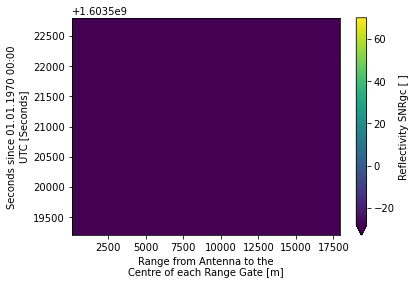

In [19]:
znc.SNRgc.plot(vmin=-28, vmax=70)